In [38]:
import pandas as pd
import numpy as np
import text_normalizer as tn
import warnings

#warnings.filterwarnings("ignore")

In [2]:
import os
import re 
import nltk

In [7]:
import pickle
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import LatentDirichletAllocation

import pyLDAvis.sklearn


In [3]:
pwd

'C:\\Users\\Sohum Pednekar\\Documents\\NLP_final'

# Topic Modeling

I used web scraped repository of Gutenberg Project Children's instrcutional books. In HW2, I web scraped and cleaned the Licensing Information. Still, this corpus of 104 books need further cleaning to getting only the content of books. For this final homework, I looked for the pattern for cleaning by opening almost 30 files randomly and used the pattern to clean the files for the content. The pattern seems to work quite good.

I normalized the corpus using Sarakar's code (text_normalizer). I modified Sarkar's code by using  Spacy's stopwordlist and many extra words I addded to stopword list as I ran the LDA model, tf-idf vectorizer several times for differnt parameters of vectorizer(min_df, max_df, ngram_range for bigram and unigram) and differnt topic numbers. I adjusted the parameters of vectorizer and LDA model and number of topics to get best perplexity score.

## Project Overview
- Aim: Review the application and development of Topic model data analysis tool on Project Gutenberg Children’s instructional books corpus. 

- Preprocessing the corpus: 
      - Clean the licensing information and keep only the content of the books
      -  Topic model pipeline: Removal of accented characters, contraction expansion, making text in lowercase, remove extra newlines and spaces, text lemmatization(SpaCy) , special character removal, stop words removal (SpaCy).

- Make a word cloud for visual representation of the most common words from the corpus.

- Vectorizing text to get Sparse matrix vector outputs and building LDA model. Used Perplexity score to decide the optimum number of topics.

- Result Visualization using pyLDAviz and Word cloud of the distinct topic. 

- **Are we able to gain an insight as to what a particular topic may actually represent from the collection of top keywords assigned to it?** 


In [4]:
corpusDir = "noLicenseTxt/"
cleanCorpus = "../cleanTxt/"


def removeLicense(textStr) :
          
    try :
        noStartTx = textStr.split('CONTENT',1)[1]
    except IndexError:
        try :
            noStartTx = textStr.split('INTRODUCTORY MATTER',1)[1]
        except IndexError:
            noStartTx = textStr.split('LESSON',1)[1]
    
    contentTx = noStartTx.split('End of the Project Gutenberg',1)[0]
    if(len(contentTx) == len(noStartTx)):
        contentTx = noStartTx.split('End of Project Gutenberg',1)[0]
        
    if(len(contentTx) == len(noStartTx)):
        contentTx = noStartTx.split('Project Gutenberg',1)[0]
     
    return contentTx


files = ".*\.txt"

os.chdir(corpusDir)
filelist = os.listdir(os.getcwd())
for i in filelist:
    if i.endswith('.txt'):
        try:
            print(i)
            txt= open(i, encoding="utf8", errors='ignore').read()
            cleanTxt = removeLicense(txt)
        except Exception as e:
            print('While reading Error code: ')
    
        try:
            
            with open(cleanCorpus + i, 'w', encoding='utf-8') as writer:
                    writer.write(cleanTxt)
                    writer.close()
        except Exception as e:
            print('While writing Error code: ')


ABookofNaturalHistoryYoungFolksLibraryVo.txt
ACatechismofFamiliarThingsTheirHistoryan.txt
AFirstSpanishReader.txt
AHistoryoftheMcGuffeyReaders.txt
While reading Error code: 
AHundredAnecdotesofAnimals.txt
ALittleBookforALittleCook.txt
While reading Error code: 
AManualofPronunciationForPracticalUseinS.txt
While reading Error code: 
AModernHistoryFromtheTimeofLuthertotheFa.txt
AmongtheFarmyardPeople.txt
AnecdotesoftheHabitsandInstinctofAnimals.txt
AnElementarySpanishReader.txt
AnimalHeroes.txt
APrimaryReaderOldtimeStoriesFairyTalesan.txt
ASchoolHistoryoftheUnitedStates.txt
BirdDayHowtoprepareforit.txt
BookaboutAnimals.txt
While reading Error code: 
BoyBlueandhisfriendsSchooled.txt
CampingForBoys.txt
CarlandtheCottonGin.txt
ChamberssElementaryScienceReadersBookI.txt
ChatterboxStoriesofNaturalHistory.txt
While reading Error code: 
ChildrensClassicsinDramaticFormBookTwo.txt
ChildsBookofWaterBirds.txt
While reading Error code: 
CommercialGeographyABookforHighSchoolsCo.txt
Contesethistoriett

## Normalizing the corpus:
Removal of accented characters, contraction expansion, making text in lowercase, remove extra newlines and spaces, text lemmatization(SpaCy) , special character removal, stop words removal (SpaCy).

In [50]:
corpusDir = "C:/Users/Sohum Pednekar/Documents/NLP_final/cleanTxt"
os.chdir(corpusDir)
flag = 0
ret = {}
filelist = os.listdir(os.getcwd())
for i in filelist:
    if i.endswith('.txt'):
        try:
            
            file = open(i, encoding="utf8", errors='ignore')
            text = file.read()
            file.close()
        except Exception as e:
            print('While reading Error code: ', e.code)
            #pass
        # normalize datasets
        normText = tn.normalize_corpus(text)
        
        ret[flag]= {'bookName': i,'bookText': normText}
        flag = flag +1
        

In [51]:
corpusDir = "C:/Users/Sohum Pednekar/Documents/NLP_final"
os.chdir(corpusDir)

filename = 'normalizedBooks'
outfile = open(filename,'wb')

pickle.dump(ret,outfile)
outfile.close()

In [52]:
#1. Now create a pandas df from the dictionary
df = pd.DataFrame(ret)
df = df.transpose()

## Word Cloud of the most common words from the corpus to verify whether the preprocessing happened correctly
it allows us to verify whether we need additional preprocessing before further analyzing the text data.


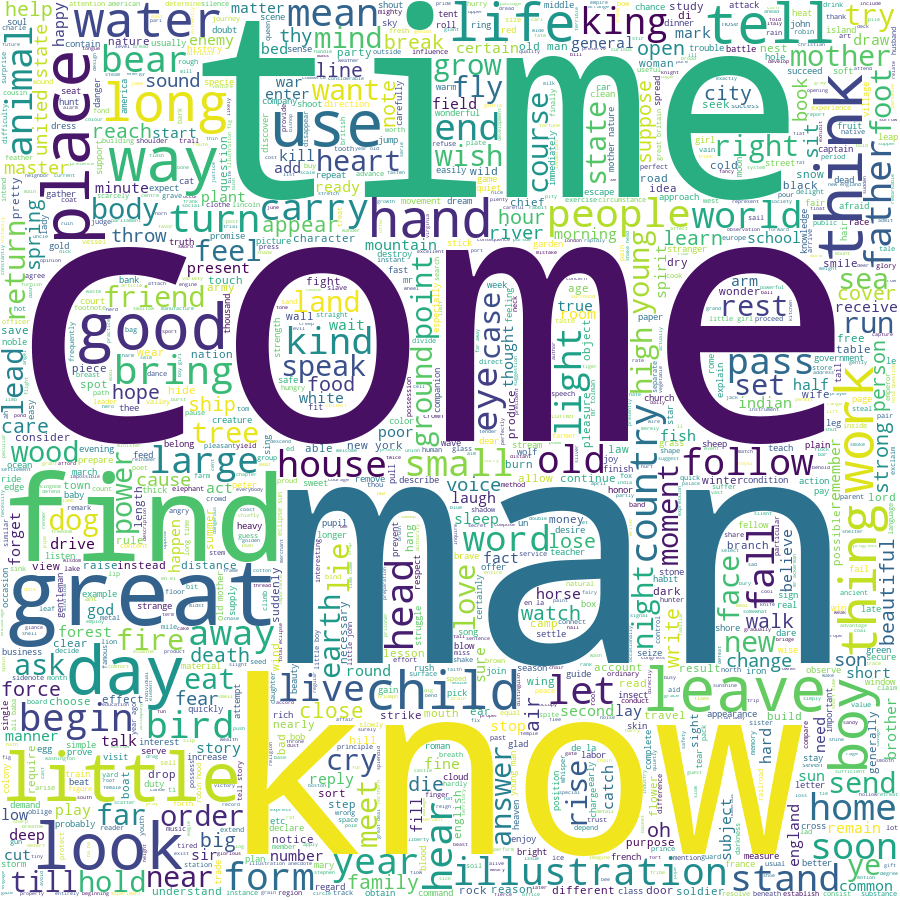

In [53]:
# Join the different processed titles together.
long_string = ','.join(list(df['bookText'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', width=900,height=900)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

## Vectorizing Texts using tfidf vectorizer to get Sparse matrix vector outputs for building LDA model

In [85]:
### stop word list
newStops = ['lesson', 'illustration', 's', 'chapter', 'edition', 'print', 'sentence', 'illustrate', 'mrs', 'author', 'copy', 'XV','XI','XXI','II','XII','XXII','III','XIII','XXIII','IV','XIV','XXIV','V','XXV','VI','XVI','XXVI','VII','XVII','VIII','IX','XIX','X','XX','thou','thee','thy','la', 'de','non','un','le','pre','con','lo','ma','par']
vectorizer = TfidfVectorizer(use_idf=True, min_df=0.3, max_df=0.6, ngram_range=(1,1), stop_words = newStops, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(df['bookText'])

## building LDA model

In [89]:
NUM_TOPICS = 4

# Latent Dirichlet Allocation Model
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=100, learning_method='online',verbose=True)
data_lda = lda.fit_transform(data_vectorized)


iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of 

## LDA perplexity score

In [90]:
## LDA perplexity score
ldaTfidfPrplx = lda.perplexity(data_vectorized.astype(float))
ldaTfidfPrplx

7976.459144260987

## Print Top 40 keywords for each topic with and without weights

In [91]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])
    

In [92]:
# code taken from https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial
# Define helper function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)
##############################################

feature_names = vectorizer.get_feature_names()
n_top_words = 40
print("\nTopics in LDA model: ")
#tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, feature_names, n_top_words)


Topics in LDA model: 

Topic #0:zone electric prince elephant map washington peter deer current smith baby hen hare rome mill queen fig chicken tis stem medicine rabbit buffalo mouse imitation ugly wire van drawing majesty eagle crow walter castle tiger lamb pig fort hammer circuit

Topic #1:jack insect elephant robin poem peter baby tom giant pupil hen prince car mouse hare queen footnote ant meaning uncle thomas oer knight rabbit poet sparrow stem tent frank william mamma nation fairy eagle washington specie deer van reader charle

Topic #2:flour fifth title bride eighth paradise test throng oer essential stain stove correspond treatment december giant christ mode streak sailor spell courage manufacture accumulate border commerce acquaint reputation toss feat heathen kneel quiver herd pond furrow gem calm principle canada

Topic #3:principle volume spell scientific translate eighth seventh sixth seventy literature adapt belief fifth science society interested title cent elementary a

### Topic number 3 is most weighted and distinct topic which is also most human interpreatble than any of the other 3 topics.

In [93]:
# Keywords for topics clustered by Latent Dirichlet Allocation
print("LDA Model:")
selected_topics(lda, vectorizer)

LDA Model:
Topic 0:
[('zone', 0.25237249396364697), ('electric', 0.252082047937642), ('prince', 0.25150718225366886), ('elephant', 0.2514914616972021), ('map', 0.25121887791631736), ('washington', 0.25120687738858893), ('peter', 0.25116666809315075), ('deer', 0.2511460235170702), ('current', 0.25113535725189257), ('smith', 0.25111159333737404)]
Topic 1:
[('jack', 4.168629918079872), ('insect', 3.9942542153272522), ('elephant', 3.7637397968776543), ('robin', 3.745872880406131), ('poem', 3.620614193341084), ('peter', 3.611520331175063), ('baby', 3.596655656769156), ('tom', 3.454601682783743), ('giant', 3.4383289113397577), ('pupil', 3.405208483768972)]
Topic 2:
[('flour', 0.2509936625419924), ('fifth', 0.2509622529239827), ('title', 0.250887559823595), ('bride', 0.2508827761769024), ('eighth', 0.25088146364435887), ('paradise', 0.2508810729113871), ('test', 0.2508734443067196), ('throng', 0.2508648464642525), ('oer', 0.2508624479031394), ('essential', 0.2508607407946049)]
Topic 3:
[('pri

In [94]:
third_topic = lda.components_[3]
third_topic.shape

(2341,)

## A wordcloud of the distinct topic (topic number 3) with the size of the words proportional to the weight 

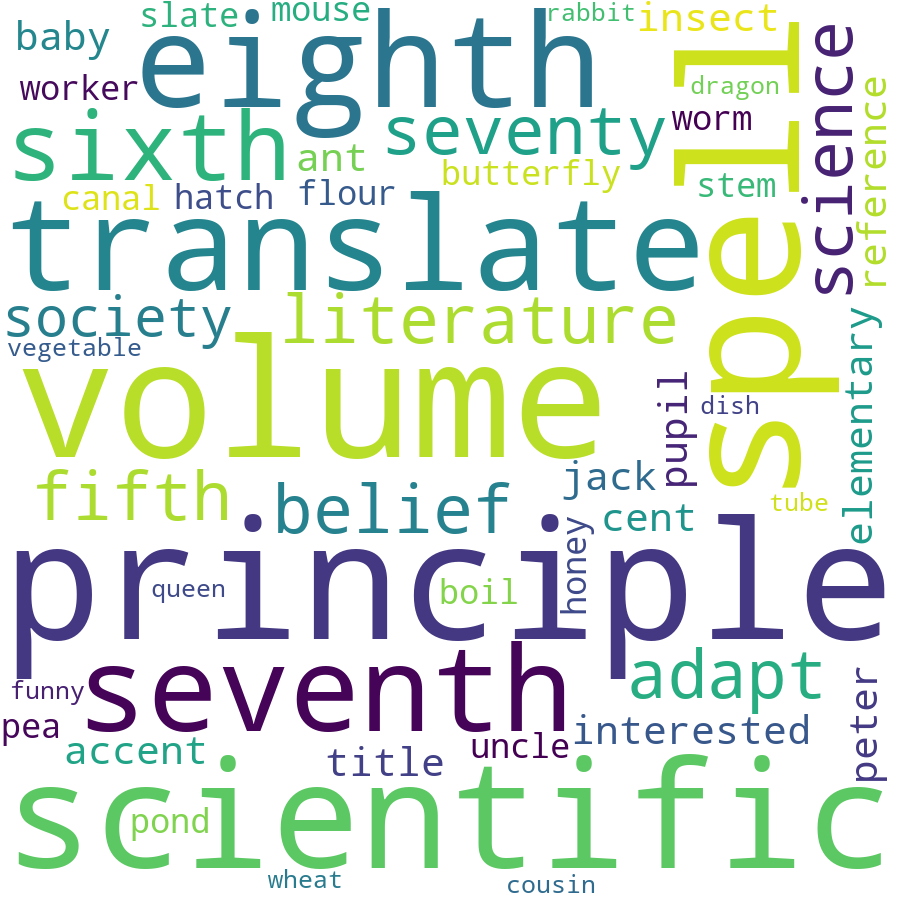

In [95]:
## Code taken from https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial
third_topic_words = [feature_names[i] for i in third_topic.argsort()[:-50 - 1 :-1]]

# Generating the wordcloud with the values under the category dataframe
thirdTopicloud = WordCloud(background_color="white", contour_width=3, contour_color='steelblue', width=900,height=900)
thirdTopicloud.generate(" ".join(third_topic_words))
thirdTopicloud.to_image()


## pyLDAVis for the LDA model results

### Got very good pyLDAvis plot as per following criteria!!!
- The larger the bubble, the more prevalent is that topic.
- A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.
- The most prevalent topic shown below by Bubble # 1 clearly shows the words related to pre-K, elementary grade level books containing nursary rhyming poem words and animals, fairy tale story books etc.

In [96]:
pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne')
dash

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1     -187.100677 -284.171356       1        1  95.523699
3       42.795307 -296.524048       2        1   1.647901
0       55.162685  -66.628822       3        1   1.414203
2     -174.733337  -54.276146       4        1   1.414198, topic_info=     Category      Freq        Term     Total  loglift  logprob
1588  Default  1.000000   principle  1.000000  30.0000  30.0000
2254  Default  0.000000      volume  0.000000  29.0000  29.0000
1124  Default  2.000000      insect  2.000000  28.0000  28.0000
1510  Default  2.000000       peter  2.000000  27.0000  27.0000
146   Default  2.000000        baby  2.000000  26.0000  26.0000
...       ...       ...         ...       ...      ...      ...
401    Topic4  0.010357    commerce  0.800942  -0.0895  -7.7576
24     Topic4  0.010357    acquaint  0.686543   0.0646  -7.7576
1714   Topic4  0.010357  reputation  0.637948   0.1380  -7.7576
2139   Topic4  0.010357        toss  0.705101   0.0379  -7.7576
800    Topic4  0.010357        feat  0.484931   0.4122  -7.7576

[246 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
13        1  1.460006      accent
24        1  1.456572    acquaint
32        1  1.200389       adapt
78        1  0.953526         ant
146       1  1.153527        baby
...     ...       ...         ...
2272      1  1.135234  washington
2299      1  1.088659     william
2306      1  0.741090        wire
2320      1  0.697099        worm
2340      1  1.268480        zone

[88 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 3])

## Conclusion

- Topic 0 and Topic 1 contains elementary grade level books. Books related to fairy tales, poems, animals.

- Topic 2 and 3 contains books on various subjects for older children of middle school grade level.

- Topics 1 and 3 are more human interpretable than topic 0 and 2 as to what topic it is about. Preprocessing is a key to get best results.

## Top 20 salient words per topic

In [97]:
#print("LDA Model:")
#selected_topics2(lda, vectorizer)

#-----Or------Or------Or------Or------Or------Or------Or------Or------
## code taken from https://blog.usejournal.com/nlp-for-topic-modeling-summarization-of-financial-documents-10-k-q-93070db96c1d
sorting=np.argsort(lda.components_)[:,::-1]
features=np.array(feature_names)
import mglearn
mglearn.tools.print_topics(topics=range(4), feature_names=features,sorting=sorting, topics_per_chunk=10, n_words=20)

topic 0       topic 1       topic 2       topic 3       
--------      --------      --------      --------      
zone          jack          flour         principle     
electric      insect        fifth         volume        
prince        elephant      title         spell         
elephant      robin         bride         scientific    
map           poem          eighth        translate     
washington    peter         paradise      eighth        
peter         baby          test          seventh       
deer          tom           throng        sixth         
current       giant         oer           seventy       
smith         pupil         essential     literature    
baby          hen           stain         adapt         
hen           prince        stove         belief        
hare          car           correspond    fifth         
rome          mouse         treatment     science       
mill          hare          december      society       
queen         queen         gia